/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/100 - Loss: 0.7406
Epoch 20/100 - Loss: 0.2417
Epoch 30/100 - Loss: -0.2996
Epoch 40/100 - Loss: -0.7530
Epoch 50/100 - Loss: -0.9651
Epoch 60/100 - Loss: -0.9545
Epoch 70/100 - Loss: -0.9733
Epoch 80/100 - Loss: -0.9813
Epoch 90/100 - Loss: -0.9816
Epoch 100/100 - Loss: -0.9842


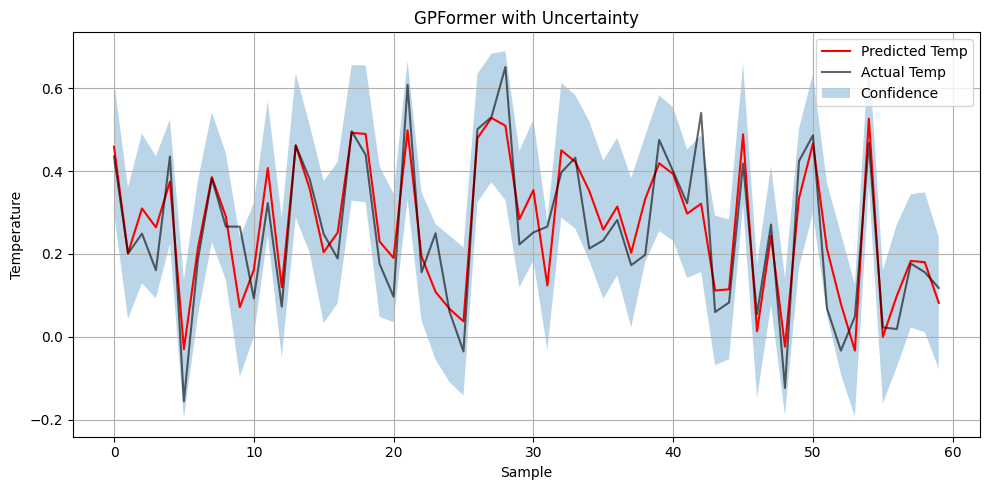

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gpytorch

# 1. Đọc và chuẩn bị dữ liệu
df = pd.read_csv("climate_change.csv")
features = ['MEI', 'CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'TSI', 'Aerosols']
target = 'Temp'

df = df.dropna()
X = df[features].values
y = df[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, seq_len=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len=12)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# 2. Transformer encoder cho feature extraction
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x: [B, T, F]
        x = self.embedding(x)      # [B, T, d_model]
        x = x.permute(1, 0, 2)     # [T, B, d_model]
        x = self.transformer(x)    # [T, B, d_model]
        return x[-1]               # lấy đặc trưng cuối cùng: [B, d_model]

# 3. GP Regression model dùng GPyTorch
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 4. Huấn luyện kết hợp Transformer + GP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = TransformerEncoder(input_dim=X_train.shape[2]).to(device)
with torch.no_grad():
    feats_train = transformer(X_train_t.to(device)).cpu()
    feats_test = transformer(X_test_t.to(device)).cpu()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_gp = GPRegressionModel(feats_train, y_train_t, likelihood)

model_gp.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model_gp.parameters()},
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gp)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model_gp(feats_train)
    loss = -mll(output, y_train_t)
    loss.backward()
    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1}/{training_iter} - Loss: {loss.item():.4f}")
    optimizer.step()

# 5. Dự đoán
model_gp.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model_gp(feats_test))
    mean = preds.mean.numpy()
    lower, upper = preds.confidence_region()

# 6. Vẽ kết quả
plt.figure(figsize=(10, 5))
plt.plot(mean, label="Predicted Temp", color='red')
plt.plot(y_test_t.numpy(), label="Actual Temp", color='black', alpha=0.6)
plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.3, label="Confidence")
plt.title("GPFormer with Uncertainty")
plt.xlabel("Sample")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


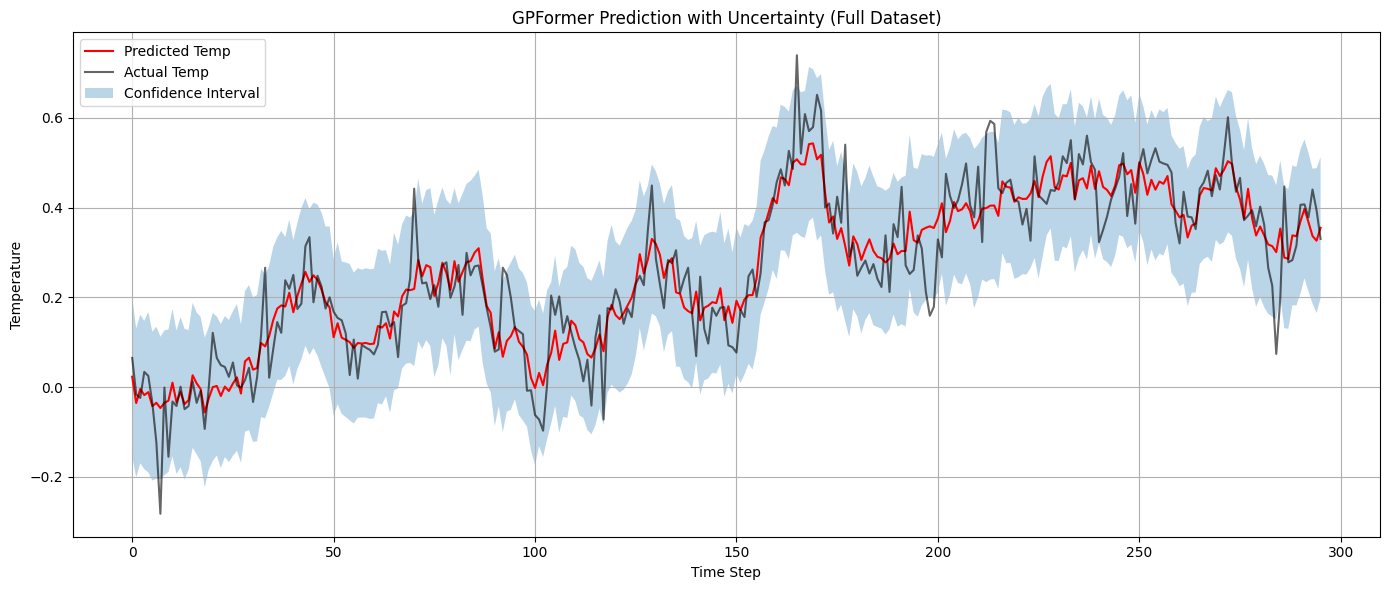

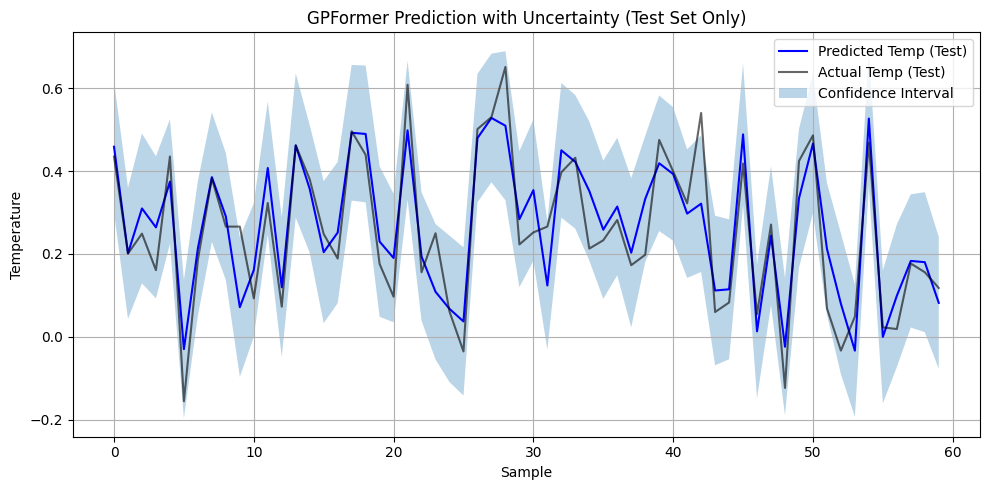

In [12]:
# 5. Dự đoán trên toàn bộ tập dữ liệu (train + test)
with torch.no_grad():
    feats_all = transformer(torch.tensor(X_seq, dtype=torch.float32).to(device)).cpu()
    preds_all = likelihood(model_gp(feats_all))
    mean_all = preds_all.mean.numpy()
    lower_all, upper_all = preds_all.confidence_region()

# Ghép ground truth thật theo y_seq (chưa split)
y_true_all = y_seq

# 6. Trực quan hóa kết quả trên toàn bộ tập dữ liệu
plt.figure(figsize=(14, 6))
plt.plot(mean_all, label="Predicted Temp", color='red')
plt.plot(y_true_all, label="Actual Temp", color='black', alpha=0.6)
plt.fill_between(np.arange(len(mean_all)), lower_all.numpy(), upper_all.numpy(), alpha=0.3, label="Confidence Interval")
plt.title("GPFormer Prediction with Uncertainty (Full Dataset)")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Trực quan hóa riêng phần dự đoán trên tập test
plt.figure(figsize=(10, 5))
plt.plot(mean, label="Predicted Temp (Test)", color='blue')
plt.plot(y_test_t.numpy(), label="Actual Temp (Test)", color='black', alpha=0.6)
plt.fill_between(np.arange(len(mean)), lower.numpy(), upper.numpy(), alpha=0.3, label="Confidence Interval")
plt.title("GPFormer Prediction with Uncertainty (Test Set Only)")
plt.xlabel("Sample")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
